# Installation

In [1]:
!pip install tnreason==0.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 913.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.2 MB/s eta 0:00:00


# Sample Generation

A Markov Logic Network describes a probability distribution of the atoms appearing in the formulas. Having defined such a distribution, one can generate samples.

## Visualization of a Markov Logic Network

We provide a graphical representation of the formulas. Therefor we represent each atom appearing in the formulas as a node and the formulas as hyperedges connecting the respective atomic nodes.

We use the following rules:
- Unterschrank(z) $\Rightarrow$ Moebel(z)
- hatLeistungserbringer(x,y) $\land$ versandterBeleg(y,x) $\Rightarrow$ Ausgangsrechnung(x)

In [2]:
expressionsDict = {
    "e0" : [["not",["Unterschrank(z)","and",["not","Moebel(z)"]]], 1.5],
    "e1" : [["not",["hatLeistungserbringer(x,y)","and",["versandterBeleg(y,x)","and",["not","Ausgangsrechnung(x)"]]]], 5]
}

In [3]:
from tnreason.model import model_visualization as mv

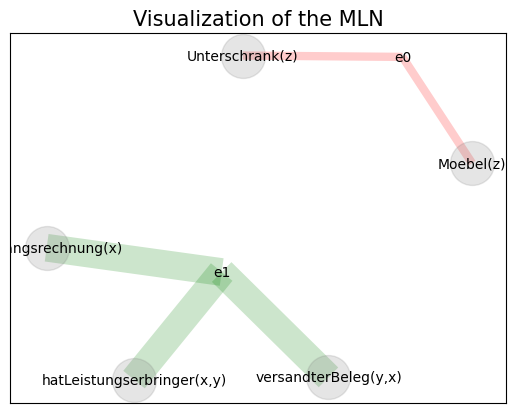

In [4]:
pos = mv.visualize_model(expressionsDict,showFormula=False)

## Generation by independent marginal distributions

A most simple strategy of drawing samples is an independent drawing of the atomic variables by their marginal distributions. However, this ignores the dependencies of the variables and is thus of limited suitability. We use this strategy to initialize samples for a Markov Chain.

In [5]:
from tnreason.model import sampling

In [6]:
sampler = sampling.GibbsSampler(expressionsDict)
evidenceDict = sampler.gibbs_sample(chainLength=0)

We add the sample to the visualization of the Markov Logic Network. To this end we assign to each atomic node a color, which is
- red if the atomic variable is false in the sample.
- blue if the atomic variable is true in the sample.

{'Ausgangsrechnung(x)': array([-0.96413185, -0.15637675]),
 'Moebel(z)': array([0.92249707, 0.35309401]),
 'Unterschrank(z)': array([-0.09400749,  1.        ]),
 'hatLeistungserbringer(x,y)': array([-0.57658906, -0.94986167]),
 'versandterBeleg(y,x)': array([ 0.2860193 , -0.93645214]),
 'e0': array([0.6139729 , 0.99207965]),
 'e1': array([-0.18776087, -0.30248309])}

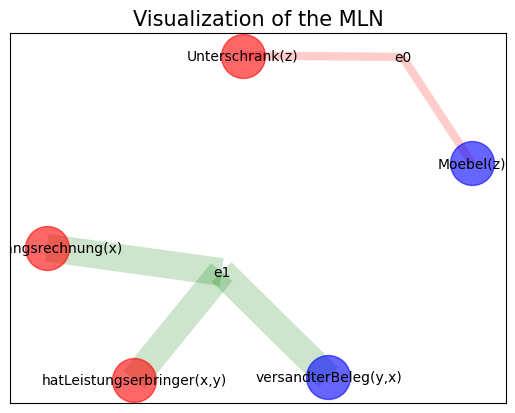

In [7]:
sampler.visualize(evidenceDict=evidenceDict, showFormula=False, pos=pos)

## Generation with Gibbs Sampling

Gibbs Sampling is a Markov Chain approach to generate a sample of the distribution, which takes the independencies into account. We iterate through the atoms and assign a new value to each atom drawn from the posterior distribution giving the rest as evidence.

{'Ausgangsrechnung(x)': array([-0.96413185, -0.15637675]),
 'Moebel(z)': array([0.92249707, 0.35309401]),
 'Unterschrank(z)': array([-0.09400749,  1.        ]),
 'hatLeistungserbringer(x,y)': array([-0.57658906, -0.94986167]),
 'versandterBeleg(y,x)': array([ 0.2860193 , -0.93645214]),
 'e0': array([0.6139729 , 0.99207965]),
 'e1': array([-0.18776087, -0.30248309])}

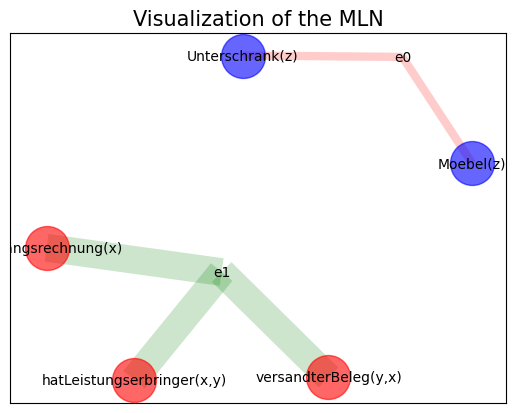

In [8]:
evidenceDict = sampler.gibbs_sample(chainLength=10)
sampler.visualize(evidenceDict=evidenceDict, showFormula=False, pos=pos)

## Generation of multiple samples

We can use the above sampling strategies to generate DataFrames, where each row is a sample.

In [9]:
sampleDf = sampler.create_sampleDf(100)

/usr/local/lib/python3.10/dist-packages/tnreason/model/sampling.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  sampleDf = pd.concat(
/usr/local/lib/python3.10/dist-packages/tnreason/model/sampling.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  sampleDf = pd.concat(
/usr/local/lib/python3.10/dist-packages/tnreason/model/sampling.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  sampleDf = pd.concat(
/usr/local/lib/python3.10/dist-packages/tnreason/model/sampling.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_on

In [10]:
sampleDf.head()

,Ausgangsrechnung(x),Moebel(z),Unterschrank(z),"hatLeistungserbringer(x,y)","versandterBeleg(y,x)"
0,0,1,1,1,0
1,1,0,1,1,0
2,1,0,0,1,1
3,1,1,1,0,1
4,1,0,1,0,1


# Inference based on Evidence

Using evidence in the form of truth assignments to variables, we infer the Markov Logic Network. The posterior distribution is then another Markov Logic Network.

There are two principle ways of inference implemented in *tnreason*:
- Based on logical inference: Manipulation of the formulas after substitution of the evidence variables.
- Based on tensor network contractions: Contractions with truth cores of the legs associated with the evidence variables.


## Logical Inference

We substitute the atoms in the formulas by their truth values, when the latter is known from the evidence Dict. After simplification of the resulting formulas we arrive at a posterior Markov Logic Network.


1. Example: Knowing that Ausgangsrechnung(x) is True effectively removes the second formula from the expression (since it is always satisfied).

In [11]:
evidenceDict = {
    "Ausgangsrechnung(x)" : True
}

In [12]:
from tnreason.model import logic_model as lm

In [13]:
logicModel = lm.LogicRepresentation(expressionsDict)
logicModel.expressionsDict

{'e0': [['not', ['Unterschrank(z)', 'and', ['not', 'Moebel(z)']]], 1.5],
 'e1': [['not',
   ['hatLeistungserbringer(x,y)',
    'and',
    ['versandterBeleg(y,x)', 'and', ['not', 'Ausgangsrechnung(x)']]]],
  5]}

In [14]:
logicModel.infer(evidenceDict)
logicModel.expressionsDict

{'e0': [['not', ['Unterschrank(z)', 'and', ['not', 'Moebel(z)']]], 1.5]}

In [15]:
sampler = sampling.ExactSampler(logicModel.expressionsDict)
sampler.compute_distributionCore(margAtoms=["Unterschrank(z)","Moebel(z)"])
posterioriDistribution = sampler.distributionCore

The posterioriDistribution stores for each truthAssignment to the remaining atoms (posteriorDistribution.colors) its probability as a coordinate of the array posterioriDistribution.values. As an example here:

In [16]:
posterioriDistribution.colors

['Moebel(z)', 'Unterschrank(z)']

In [17]:
posterioriDistribution.values

array([[0.31025741, 0.06922778],
       [0.31025741, 0.31025741]])

The probability of "Moebel(z)" False and "Unterschrank(z)" True is thus:

In [18]:
posterioriDistribution.values[0, 1]

0.069227784501931

2. Example: Knowing that versandterBeleg(y,x) is True reduces the body of the second rule to the other condition hatLeistungserbringer(x,y).

In [19]:
evidenceDict = {
    "versandterBeleg(y,x)" : True
}

In [20]:
logicModel = lm.LogicRepresentation(expressionsDict)
logicModel.infer(evidenceDict)
logicModel.expressionsDict

{'e0': [['not', ['Unterschrank(z)', 'and', ['not', 'Moebel(z)']]], 1.5],
 'e1': [['not',
   ['hatLeistungserbringer(x,y)', 'and', ['not', 'Ausgangsrechnung(x)']]],
  5]}

## Tensor-based Inference

Another method is to contract the probability tensor of the prior MLN with the cores representing the evidence. This is a more general method for inference compared with the logic-based approach, since also noisy evidence can be infered.

In [21]:
from tnreason.model import tensor_model as tm

In [22]:
evidenceDict = {
    "Ausgangsrechnung(x)" : True
}

In [23]:
tensorModel = tm.TensorRepresentation(expressionsDict)

Compute the posteriori Distribution in the form of an Tensor storing the truth assignment probabilities.

In [24]:
posterioriDistribution = tensorModel.evidence_contraction(evidenceDict).normalize()

Investigate, which axis of the Tensor corresponds with which atom.

In [25]:
posterioriDistribution.colors

['Moebel(z)',
 'Unterschrank(z)',
 'versandterBeleg(y,x)',
 'hatLeistungserbringer(x,y)']

Calculate the probability of "Moebel(z)=False" (slice 0 on the Moebel(z) axis) and "Unterschrank(z)=True" (slice 1 on the Unterschrank(z) axis). The axis of "versandterBeleg(y,x)" and "hatLeistungserbringer(x,y)" are summed over, which is a marginalization process. Since this assignment does not satisfy the first rule in the expressionsDict, it is of little probability.

In [26]:
import numpy as np
np.sum(posterioriDistribution.values[0,1, : , : ])

0.069227784501931